In [2]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention

from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast

from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import plot_model
from functools import partial
import seaborn as sns
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [25]:
learning_rate = 0.0001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 15
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
num_layers = 15
Hidden_size=64
mlp_head_units = 1024

# Data Preparation

In [26]:
train_data='archive/Training'
test_data='archive/Testing'

In [27]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


# Data Visualization

2024-04-21 16:20:18.136914: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4570]
	 [[{{node Placeholder/_0}}]]
2024-04-21 16:20:18.137383: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4570]
	 [[{{node Placeholder/_4}}]]


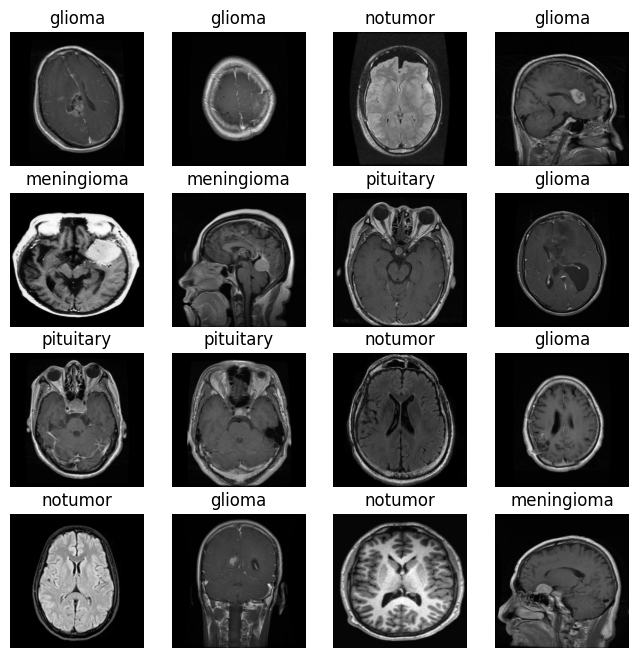

In [28]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))): 
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')  
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()

# Data Augmentation

In [29]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])

In [30]:
# Define a custom preprocessing function
def process_data(image, label):
    augmented_image=augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [31]:
vali_dataset=(
   val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)

)

In [32]:
input_tensor = next(iter(training_dataset))[0]

2024-04-21 16:20:27.284629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype resource
	 [[{{node Placeholder/_24}}]]
2024-04-21 16:20:27.285128: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4570]
	 [[{{node Placeholder/_4}}]]


In [33]:
patche=tf.image.extract_patches(images=input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')
                                


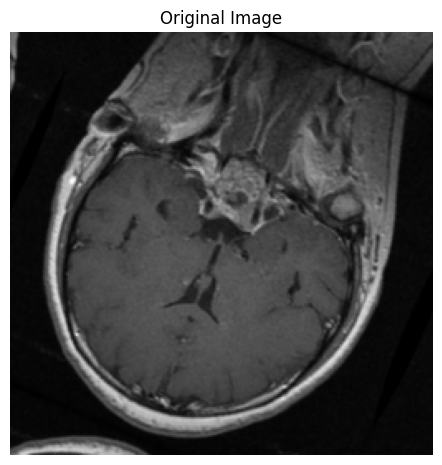

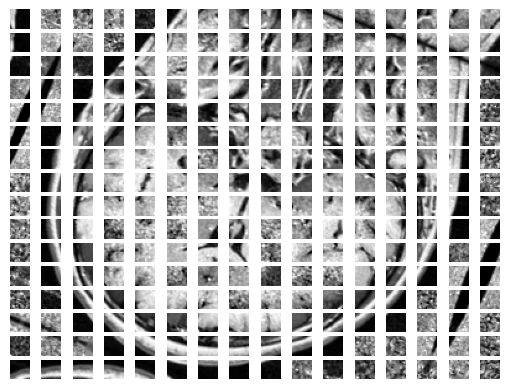

In [34]:
plt.figure(figsize=(12, 12))

batch_size, patch_rows, patch_cols, channels = patche.shape
plt.subplot(1, 2, 1)
plt.imshow(input_tensor[0],cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        plt.imshow(patche[0, i, j, :].numpy().reshape (patch_size,patch_size, 1),cmap='gray')
        plt.axis("off")

plt.show()


# VIT Model

In [35]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size,Hidden_size):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection=Dense(Hidden_size)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=Hidden_size
        )
        
        self.num_patches=num_patches

    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        patches=tf.image.extract_patches(images=image,
                                sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID'
                                )
       
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        embedding_input=tf.range(start=0,limit =self.num_patches,delta=1)
        output=self.linear_projection(patches)+ self.position_embedding(embedding_input)
        return output

In [36]:
class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads,Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1=LayerNormalization()
        self.layer_norm_2=LayerNormalization()
        
        self.multi_head_att=MultiHeadAttention(Num_heads,Hidden_size)
        
        self.dense_1=Dense(Hidden_size,activation=tf.nn.gelu)
        self.dense_2=Dense(Hidden_size,activation=tf.nn.gelu)


    def call(self, input):
        x=self.layer_norm_1(input)
        x1=self.multi_head_att(x,x)
        
        x1=Add()([x1,input])
        x2=self.layer_norm_2(x1)
        x2=self.dense_1(x2)
        output=self.dense_1(x2)
        output=Add()([output,x1])
      
        return output


In [37]:
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers
        
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)

In [38]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [39]:
metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [40]:
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
                   loss=loss_funcion,
                   metrics=metrics

)

In [41]:

checkpoint_filepath = "Desktop/BAIT"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [42]:
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]
    
)

Epoch 1/15
143/143 [==============================] - ETA: 0s - loss: 30.0926 - accuracy: 0.4243 - top_k_accuracy: 0.7142

2024-04-21 16:27:20.587137: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1142]
	 [[{{node Placeholder/_0}}]]
2024-04-21 16:27:20.587483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1142]
	 [[{{node Placeholder/_4}}]]


143/143 [==============================] - 426s 3s/step - loss: 30.0926 - accuracy: 0.4243 - top_k_accuracy: 0.7142 - val_loss: 7.1366 - val_accuracy: 0.4571 - val_top_k_accuracy: 0.7207
Epoch 2/15
143/143 [==============================] - 793s 6s/step - loss: 4.5691 - accuracy: 0.5379 - top_k_accuracy: 0.7910 - val_loss: 3.8000 - val_accuracy: 0.5088 - val_top_k_accuracy: 0.8433
Epoch 3/15
143/143 [==============================] - 428s 3s/step - loss: 3.0397 - accuracy: 0.5687 - top_k_accuracy: 0.8219 - val_loss: 2.0852 - val_accuracy: 0.6077 - val_top_k_accuracy: 0.8538
Epoch 4/15
143/143 [==============================] - 428s 3s/step - loss: 2.5626 - accuracy: 0.5880 - top_k_accuracy: 0.8254 - val_loss: 2.2476 - val_accuracy: 0.5736 - val_top_k_accuracy: 0.8266
Epoch 5/15
143/143 [==============================] - 425s 3s/step - loss: 1.9026 - accuracy: 0.6249 - top_k_accuracy: 0.8510 - val_loss: 1.9519 - val_accuracy: 0.5709 - val_top_k_accuracy: 0.8336
Epoch 6/15
143/143 [=====

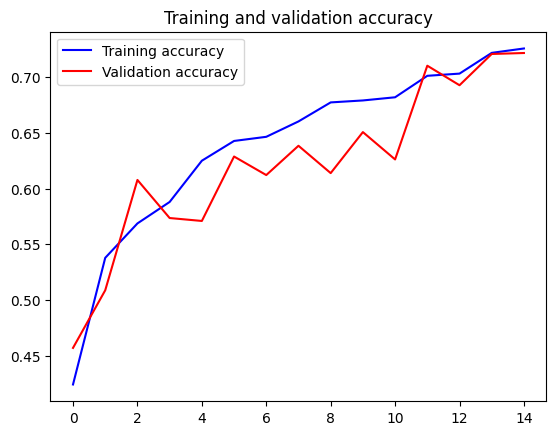

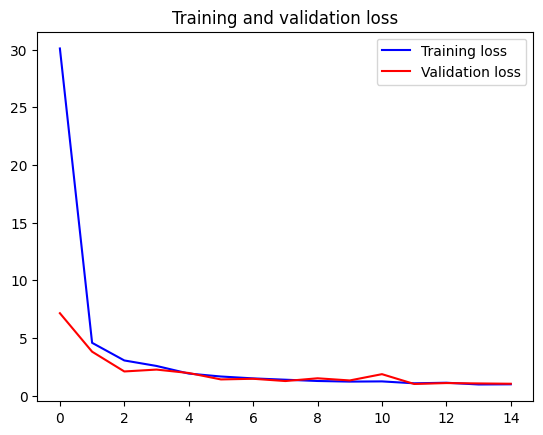

In [43]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
vit.save('brain_tumor')

INFO:tensorflow:Assets written to: brain_tumor/assets


INFO:tensorflow:Assets written to: brain_tumor/assets


In [45]:
vit.save_weights('brain_tumor')

# Prediction

In [46]:
pred = vit.predict(test_dataset)

2024-04-21 18:15:45.763788: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1311]
	 [[{{node Placeholder/_4}}]]
2024-04-21 18:15:45.764349: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1311]
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 46s 1s/step


In [47]:
vit.evaluate(test_dataset)

41/41 [==============================] - 45s 1s/step - loss: 1.2434 - accuracy: 0.6857 - top_k_accuracy: 0.8886


[1.243364930152893, 0.6857360601425171, 0.8886346220970154]

In [48]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())

In [49]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

2024-04-21 18:19:30.230754: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1311]
	 [[{{node Placeholder/_4}}]]
2024-04-21 18:19:30.231193: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1311]
	 [[{{node Placeholder/_0}}]]


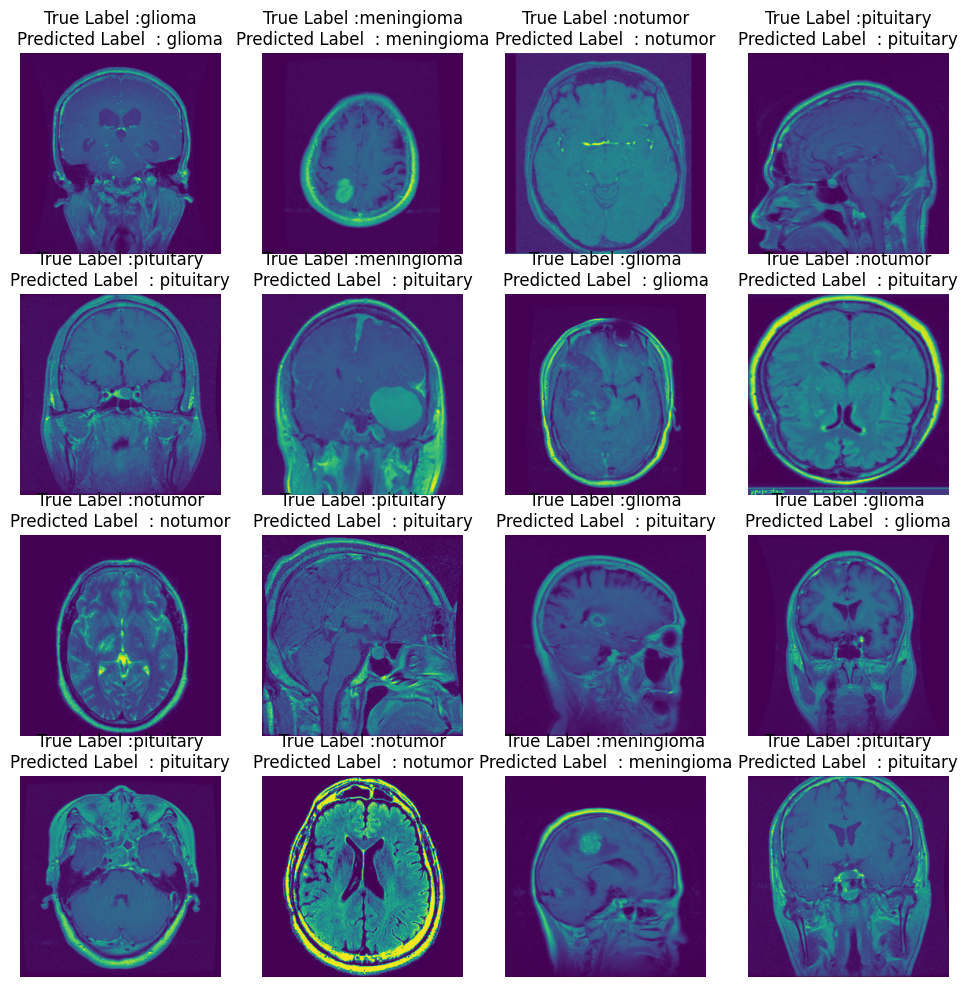

In [50]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

# Confusion Matrix

[[199  57   0  44]
 [ 61 125  38  82]
 [ 14  45 301  45]
 [ 12   8   6 274]]


Text(0.5, 58.7222222222222, 'Predicted')

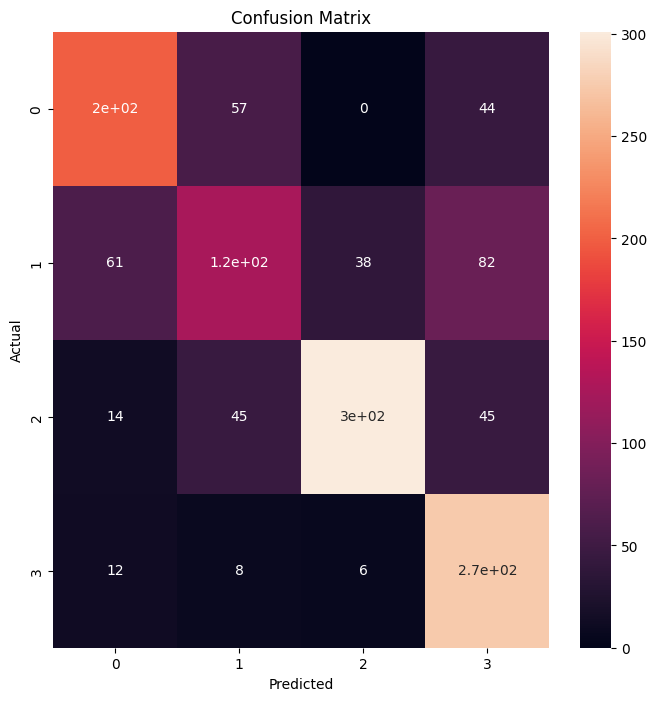

In [52]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")